### Load data

In [43]:
from pathlib import Path

import numpy as np
from numba import njit, prange

from matplotlib import pyplot as plt

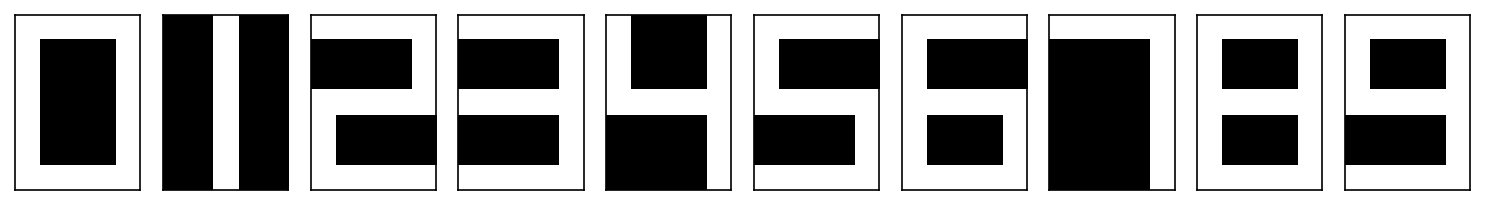

In [44]:
img_shape = (7, 5)
img_size = 35

data_path = Path(r'D:/Development/Data/datasets/txt/numbers_7x5.txt')
data_mtrx = np.loadtxt(data_path)

fig, axes = plt.subplots(nrows=1, ncols=10)

fig.set_dpi(150)
fig.set_figwidth(10)
fig.set_figheight(5)

for n, ax in zip(data_mtrx, axes.ravel()):
    ax.imshow(n.reshape(img_shape), cmap='binary_r')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

### Generate dataset

In [45]:
def one_hot_encoding(n: int, idx: int) -> np.ndarray:
    q = np.zeros(n)
    q[idx] = 1.0
    return q

In [46]:
features = []
labels = []

for i, reference_sample in enumerate(data_mtrx):
    features.append(reference_sample)
    labels.append(one_hot_encoding(10, i))

    for j in range(9):
        noised_sample = reference_sample + np.random.uniform(0.0, 0.25, img_size)
        
        features.append(noised_sample)
        labels.append(one_hot_encoding(10, i))

features = np.array(features)
labels = np.array(labels)

### Split dataset to test and train

In [47]:
test_frac = 0.2

p = np.arange(10)

test_size = int(p.size * test_frac)
train_size = int(p.size * (1 - test_frac))

idx_test = np.ravel([(p[0:test_size] + i * 10) for i in range(10)])
idx_train = np.ravel([(p[test_size:p.size] + i * 10) for i in range(10)])

x_test = np.array(features[idx_test])
y_test = np.array(labels[idx_test])

x_train = np.array(features[idx_train])
y_train = np.array(labels[idx_train])

### Define activation functions

In [57]:
@njit(fastmath=True)
def ReLU(x: np.ndarray, p: np.ndarray, q: np.ndarray, c: np.ndarray, d: np.ndarray) -> np.ndarray:
    return (p * (x + c) + d) * ((x + c) >= 0) + (q * (x + c) + d) * ((x + c) < 0)


@njit(fastmath=True)
def dReLU(x: np.ndarray, p: np.ndarray, q: np.ndarray, c: np.ndarray) -> np.ndarray:
    return p * ((x + c) >= 0) + q * ((x + c) < 0)


@njit(fastmath=True)
def dReLU_dp(x: np.ndarray, c: np.ndarray) -> np.ndarray:
    return x * ((x + c) >= 0)


@njit(fastmath=True)
def dReLU_dq(x: np.ndarray, c: np.ndarray) -> np.ndarray:
    return x * ((x + c) < 0)


@njit(fastmath=True)
def dReLU_dc(x: np.ndarray, p: np.ndarray, q: np.ndarray, c: np.ndarray) -> np.ndarray:
    return p * ((x + c) >= 0) + q * ((x + c) < 0)


@njit(fastmath=True)
def dReLU_dd(x: np.ndarray, c: np.ndarray) -> np.ndarray:
    return 1 * ((x + c) >= 0) + 1 * ((x + c) < 0)


@njit(fastmath=True)
def softmax(x: np.ndarray) -> np.ndarray:
    y = np.exp(x)
    return y / np.sum(y)

### Define model

In [58]:
@njit(fastmath=True)
def grads(x_batch: np.ndarray, y_batch: np.ndarray, V: np.ndarray, W: np.ndarray, a: np.ndarray, b: np.ndarray, p: np.ndarray, q: np.ndarray, c: np.ndarray, d: np.ndarray) -> tuple[np.ndarray]:
    dV = np.zeros(V.shape)
    da = np.zeros(a.shape)

    dW = np.zeros(W.shape)
    db = np.zeros(b.shape)

    dp = np.zeros(p.shape)
    dq = np.zeros(q.shape)

    dc = np.zeros(c.shape)
    dd = np.zeros(d.shape)
    
    for i in prange(x_batch.shape[0]):
        u = V @ x_batch[i] + a
        h = ReLU(u, p, q, c, d)
        y = softmax(W @ h + b)

        dLdh = W.T @ (y - y_batch[i])
        
        dV += np.outer(dLdh * dReLU(u, p, q, c), x_batch[i])
        da += dLdh * dReLU(u, p, q, c)

        dW += np.outer(y - y_batch[i], h)
        db += y - y_batch[i]

        dp += dLdh * dReLU_dp(u, c)
        dq += dLdh * dReLU_dq(u, c)

        dc += dLdh * dReLU_dc(u, p, q, c)
        dd += dLdh * dReLU_dd(u, c)
        
    return (dV, dW, da, db, dp, dq, dc, dd)

class Perceptron:
    def __init__(self, nIn: int, nH: int, nOut: int) -> None:
        self.nIn = nIn
        self.nH = nH
        self.nOut = nOut
        
        self.V: np.ndarray = np.random.uniform(-1, 1, (nH, nIn))
        self.a: np.ndarray = np.zeros(nH)

        self.W: np.ndarray = np.random.uniform(-1, 1, (nOut, nH))
        self.b: np.ndarray = np.zeros(nOut)

        self.p = np.zeros(nH)
        self.q = np.zeros(nH)

        self.c = np.zeros(nH)
        self.d = np.zeros(nH)

    def predict(self, x:np.ndarray) -> np.ndarray:
        u = self.V @ x + self.a
        h = ReLU(u, self.p, self.q, self.c, self.d)
        return softmax(self.W @ h + self.b)

    def loss(self, x: np.ndarray, y: np.ndarray) -> float:        
        ypred = np.array([self.predict(xi) for xi in x])
        h = -np.mean(y * np.log(ypred), axis=1)
        return np.mean(h)

    def train(self, xTrain: np.ndarray, yTrain: np.ndarray, lr, batch_size, max_epoch) -> None:
        n = xTrain.shape[0]

        for epoch in range(max_epoch):
            idxs = np.random.permutation(n)

            for i in range(n // batch_size):
                ibegin, iend = i * batch_size, min((i + 1) * batch_size, n-1)
                batch_idxs = idxs[ibegin:iend]

                dV, dW, da, db, dp, dq, dc, dd = grads(xTrain[batch_idxs], yTrain[batch_idxs], self.V, self.W, self.a, self.b, self.p, self.q, self.c, self.d)

                self.V -= lr * dV
                self.a -= lr * da

                self.W -= lr * dW
                self.b -= lr * db

                self.p -= lr * dp
                self.q -= lr * dq

                self.c -= lr * dc
                self.d -= lr * dd

### Create and train model

In [65]:
nIn = 35
nH = 3
nOut = 10

learning_rate = 1e-2
batch_size = 8
max_epoch = 256

model = Perceptron(nIn, nH, nOut)

print('untrained loss: ', model.loss(x_test, y_test).round(6))

model.train(
    x_train,
    y_train,
    learning_rate,
    batch_size,
    max_epoch
)

print('trained loss: ', model.loss(x_test, y_test).round(6))

n_true_pos = 0

for x, y in zip(x_test, y_test):
    y_pred = model.predict(x)
    n_true_pos += 1 if np.argmax(y_pred) == np.argmax(y) else 0

accuracy = n_true_pos / x_test.shape[0]
print(f"test set accuracy: {round(accuracy * 100, 2)}%")

untrained loss:  0.230259
trained loss:  0.000447
test set accuracy: 100.0%


### Test model on big number of noised samples

In [66]:
n_samples = 10000
noise_size = 1.0

n_true_pos = 0

for i in range(n_samples):
    j = i % 10
    x = data_mtrx[j] + np.random.uniform(0, noise_size, img_size)
    y = model.predict(x)
    n_true_pos += 1 if j == np.argmax(y) else 0

print(f"accuracy: {round(n_true_pos / n_samples * 100, 2)}%")

accuracy: 56.98%


### Visualize model predictions

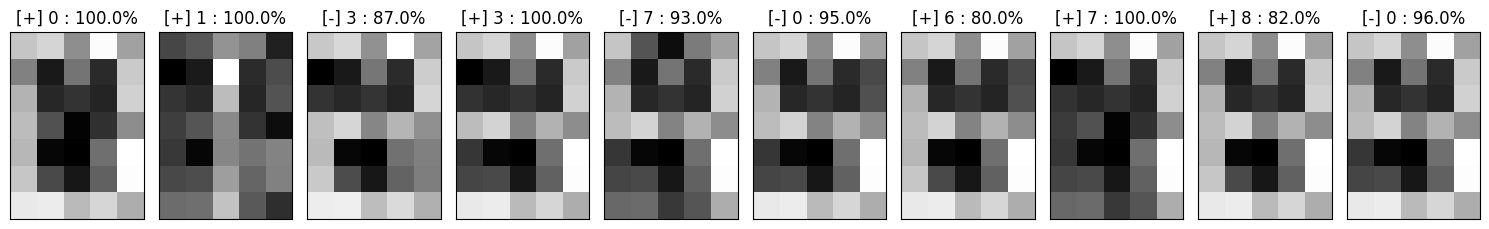

In [52]:
noise_size = 1.0

x_noised = data_mtrx + np.random.uniform(0.0, noise_size, img_size)
y = list([model.predict(xi) for xi in x_noised])

fig, axes = plt.subplots(nrows=1, ncols=10)

fig.set_dpi(100)
fig.set_figwidth(15)
fig.set_figheight(5)

for i, ax in enumerate(axes.ravel()):
    ax.imshow(x_noised[i].reshape(img_shape),  cmap='binary_r')
    j = np.argmax(y[i])

    ax.set_title(f"[{'+' if j == i else '-'}] {j} : {(y[i][j] * 100).round()}%")
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

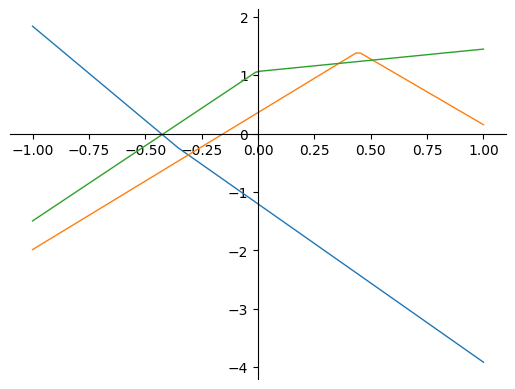

In [67]:
x = np.linspace(-1, 1, 100)

for p, q, c, d in zip(model.p, model.q, model.c, model.d):
    y = (p * (x + c) + d) * ((x + c) >= 0) + (q * (x + c) + d) * ((x + c) < 0)
    plt.plot(x, y, lw=1)

ax = plt.gca()
ax.spines['top'].set_color('none')
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')

plt.show()

In [54]:
print(model.c)
print(model.d)

[-0.02243815  0.01446016  0.14439415  0.08365049 -0.07458773 -0.0169914
  0.02574584  0.01148752 -0.01398511  0.04321349]
[-0.45165983  0.01348299  0.31765221  0.37126071  0.03588889 -0.03195792
  0.09731432  0.09603426 -0.52020389  0.25196419]
